# Segundo Projecto CRC 

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
from networkx.algorithms import community
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from networkx.drawing.nx_pydot import write_dot
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics.pairwise import euclidean_distances
from networkx.algorithms import approximation as apxa
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## General Functions

In [6]:
warnings.filterwarnings('ignore')

def calculate_scores(y_test, y_pred, draw=False):
                     
    conf_matrix = confusion_matrix(y_test, y_pred)
        
    accuracy = (conf_matrix[0,0] + conf_matrix[1,1]) / sum(sum(conf_matrix))
    sensitivity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
    specificity = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
    fscore = f1_score(y_test, y_pred, average='weighted')
    
    if draw:
        print('Accuracy    : ', accuracy) 
        print('Sensitivity : ', sensitivity) 
        print('Specificity : ', specificity) 
        print('Recall      : ', recall_score(y_test, y_pred, average='weighted')) 
        print('Precision   : ', precision_score(y_test, y_pred, average='weighted'))
        print('F1 score    : ', fscore) 

    return fscore


def use_knn(X_train, y_train, X_test, n=10):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
        
    model = knn.fit(X_train, y_train)
    return model.predict(X_test)

### Pre Process Functions

In [7]:
def handle_binary_column(df, att):
    label_encoder = LabelEncoder()
    #df[att] = label_encoder.fit_transform(df[att])
    return df


def handle_numeric_column(df, att):
    min_max_scaler = MinMaxScaler()
    df[att] = df[att].astype(float)
    df[att] = min_max_scaler.fit_transform(df[[att]])
    return df


def handle_na_column_mean(df, att):
    df[att] = pd.to_numeric(df[att], errors='ignore')
    mean_df = df[att].dropna().mean()
    df[att] = df[att].fillna(mean_df)
    return df


def handle_na_column_median(df, att):
    median = df[att].dropna().median()
    df[att] = df[att].fillna(median)
    return df


def handle_na_column_mode(df, att):
    mode = df[att].dropna().mode()[0]
    df[att] = df[att].fillna(mode)
    return df


def drop_column_na(df):
    return df.loc[:, df.isnull().mean() < 0.8]


def pre_process_data(df, handle_na, classes=[]):
    for att in df.columns:
        if df[att].isnull().sum().sum() != 0 and att not in classes:
            df = handle_na(df, att)
        if att not in classes:
            df = handle_numeric_column(df, att)
        if att == 'dx':
            df = handle_binary_column(df, att)
    return df


def pre_process(training, method):
    new_df = pre_process_data(training, method, classes=['subjectid', 'dx'])

    return new_df


def pre_process_drop(training, method):
    new_df = pre_process_data(drop_column_na(training), method, classes=['subjectid', 'dx'])

    return new_df


def find_best_method(data_set, draw=False):
    methods = {handle_na_column_median:'Handle Median', handle_na_column_mean:'Handle Mean', handle_na_column_mode:'Handle Mode'}
    labels = data_set['dx']
    
    for method, method_name in methods.items():
        
        data_set_new = pre_process_drop(data_set, method)
        data_set_new_drop = data_set_new.drop(['Unnamed: 0'], axis=1).drop(['subjectid'], axis=1).drop(['dx'], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(data_set_new_drop, labels, train_size=0.7, random_state=42)
        y_predict = use_knn(X_train, y_train, X_test, 5)
       
        score = calculate_scores(y_test, y_predict)
        
        if draw:
            print("With " + method_name + " method " + "score of: ")
            print()
            print(score)


def get_percentage_missing(data_frame):
    
    num = data_frame.isnull().sum()
    den = len(data_frame)
    
    return round(num/den, 2)
    

### Find Best Parameters

In [8]:
df = pd.read_csv('joined_data.csv', sep="," ,error_bad_lines=False, low_memory=False)

drop_cols = []

for i, row in df.dtypes.iteritems():
    if row == object and i!= 'subjectid' and i!='dx':
        drop_cols.append(i)

df_medic = df.drop(drop_cols, axis=1)
df_medic_0 = df_medic.copy()

#get_percentage_missing(df_medic_0)
#find_best_method(df_medic_0)

In [2]:
df_medic_mean = pre_process_drop(df_medic_0, handle_na_column_mean)
df_medic_mean.to_csv("processed_medic.csv")

NameError: name 'df_medic_mean' is not defined

## Build Adjacency Matrix Based on Similarity

In [3]:
medic_mean_drop = pd.read_csv('processed_medic.csv')

labels = medic_mean_drop['dx']
ids = medic_mean_drop['subjectid']

medic_mean_drop = medic_mean_drop.drop(['Unnamed: 0'], axis=1).drop(['subjectid'], axis=1).drop(['dx'], axis=1)

## Find Besk K Features

In [4]:
def find_best_features(X, y, feature_range=range(5,300)):
    best, best_comp = 0, 0
    scores = []
    
    for comp in feature_range:
        X_new = SelectKBest(chi2, k=comp).fit_transform(X.copy(), y.copy())
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size=0.7, random_state=42)
        y_predict = use_knn(X_train, y_train, X_test, 5)
        score = calculate_scores(y_test, y_predict)
       
        if score > best:
            best_comp = comp
            best = score
            
        scores += [score]
        
    return best_comp

In [5]:
#best_comp = find_best_features(medic_mean_drop, labels)
medic_mean_drop_new = SelectKBest(chi2, k=15).fit_transform(medic_mean_drop.copy(), labels.copy())
#print(best_comp) score 0.7157560437187312

In [6]:
def build_adjacency_matrix(data_frame, distance_metric, threshold=2):
    
    distances = distance_metric(data_frame)
    size = len(distances)
    size_temp = 0
    temp_value = 0
    adj_matrix = np.zeros(shape=(size, size))
    
    for row in range(size):
        size_temp = len(distances[row])
        for value in range(size_temp):
            temp_value = distances[row][value]
            if temp_value > 0 and temp_value  <= threshold:
                adj_matrix[row][value] = 1
            else:
                continue
    return np.matrix(adj_matrix)

### Build Graph

In [7]:
def create_attributes(disorder, subjectID):
    dis = {}
    s_id={}
    size = len(disorder)
    
    for i in range(size):
        s_id[i] = subjectID[i]
        dis[i] = disorder[i]
    return s_id, dis

In [8]:
matrix = build_adjacency_matrix(medic_mean_drop_new, euclidean_distances, 0.1)

G = nx.from_numpy_matrix(matrix)

s_ids, disorders = create_attributes(labels,ids)

nx.set_node_attributes(G, 'subjectID', s_ids)
nx.set_node_attributes(G, 'disorder', disorders)

#write_dot(G, 'disorders.dot')

### Clustering

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


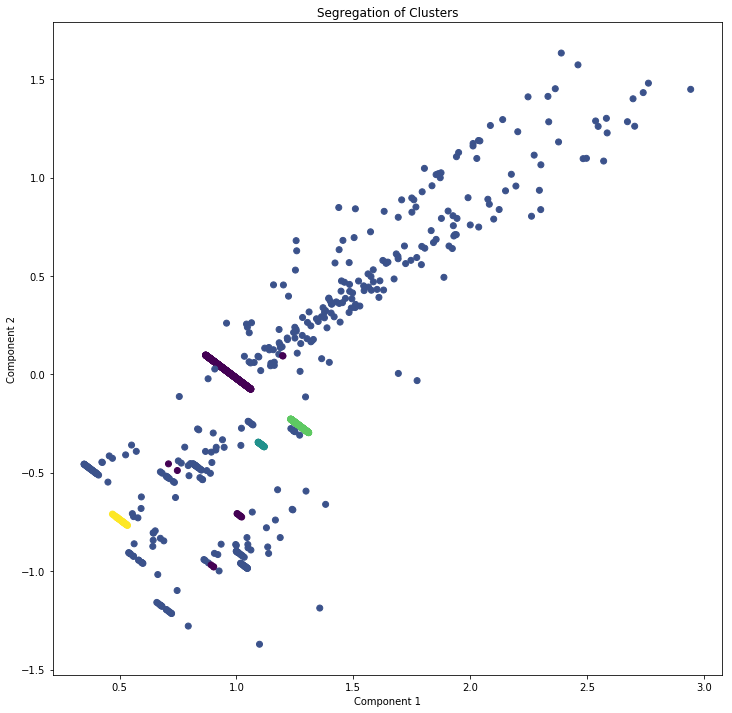

In [28]:
adj_mat = nx.to_numpy_matrix(G)

clusters = SpectralClustering(n_clusters=5, random_state=42, n_jobs=-1, n_init=1000).fit_predict(medic_mean_drop_new)

sc = SpectralClustering(5, affinity='precomputed',random_state=42, n_jobs=-1, n_init=1000).fit_predict(adj_mat)


svd_model = TruncatedSVD(n_components=2)  # 2 components

lda_output_svd = svd_model.fit_transform(medic_mean_drop_new)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]



plt.figure(figsize=(12, 12))
#plt.scatter(x, y, c=clusters)
plt.scatter(x, y, c=sc)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Clusters" )
#plt.savefig("clusters.png")
plt.show()